In [1]:
from image_process import resize_to_square
from data import read_class_names
from post_process import *
from yolov3 import Create_YOLOv3

import tensorflow as tf

In [2]:
yolo = Create_YOLOv3(num_class=2)
yolo.load_weights("checkpoints/fungi_custom")
weight = yolo.get_weights()

input_size = 416
score_threshold = 0.3
iou_threshold=0.45
sigma=0.3
method='nms'

model=yolo

In [3]:
def my_def(original_image) :
    
    class_names = read_class_names('fungi.names')

    image_data = resize_to_square(np.copy(original_image), target_size=input_size)

    image_data = image_data[np.newaxis, ...].astype(np.float32)   
    
    pred_bbox = model.predict(image_data)

    pred_bbox = [tf.reshape(x, (-1, tf.shape(x)[-1])) for x in pred_bbox]
    pred_bbox = tf.concat(pred_bbox, axis=0)

    bboxes = postprocess_boxes(pred_bbox, original_image, input_size, score_threshold)

    classes_in_img = list(set(bboxes[:, 5]))
    best_bboxes = []

    for cls in classes_in_img:
        cls_mask = (bboxes[:, 5] == cls)
        cls_bboxes = bboxes[cls_mask]
        
        # 1. 경계 상자의 개수가 0보다 큰지 확인
        while len(cls_bboxes) > 0:
            # 2. 점수 순서 A에 따라 가장 높은 점수를 갖는 경계 상자를 선택
            max_ind = np.argmax(cls_bboxes[:, 4])
            best_bbox = cls_bboxes[max_ind]
            best_bboxes.append(best_bbox)
            cls_bboxes = np.concatenate([cls_bboxes[: max_ind], cls_bboxes[max_ind + 1:]])
            
            # 3. 경계 상자 A를 계산하고 경계 상자의 모든 iou를 계산하고 iou 값이 임계값보다 높은 경계 상자를 제거
            iou = bboxes_iou(best_bbox[np.newaxis, :4], cls_bboxes[:, :4])
            weight = np.ones((len(iou),), dtype=np.float32)

            assert method in ['nms', 'soft-nms']

            if method == 'nms':
                iou_mask = iou > iou_threshold
                weight[iou_mask] = 0.0

            if method == 'soft-nms':
                weight = np.exp(-(1.0 * iou ** 2 / sigma))

            cls_bboxes[:, 4] = cls_bboxes[:, 4] * weight
            score_mask = cls_bboxes[:, 4] > 0.
            cls_bboxes = cls_bboxes[score_mask]
            
    return best_bboxes

In [4]:
def bbox_giou(boxes1, boxes2):
    boxes1 = tf.concat([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                        boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
    boxes2 = tf.concat([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                        boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1)

    boxes1 = tf.concat([tf.minimum(boxes1[..., :2], boxes1[..., 2:]),
                        tf.maximum(boxes1[..., :2], boxes1[..., 2:])], axis=-1)
    boxes2 = tf.concat([tf.minimum(boxes2[..., :2], boxes2[..., 2:]),
                        tf.maximum(boxes2[..., :2], boxes2[..., 2:])], axis=-1)

    boxes1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    boxes2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])

    left_up = tf.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down = tf.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = tf.maximum(right_down - left_up, 0.0)
    inter_area = inter_section[..., 0] * inter_section[..., 1]
    union_area = boxes1_area + boxes2_area - inter_area

    iou = inter_area / union_area

    enclose_left_up = tf.minimum(boxes1[..., :2], boxes2[..., :2])
    enclose_right_down = tf.maximum(boxes1[..., 2:], boxes2[..., 2:])
    enclose = tf.maximum(enclose_right_down - enclose_left_up, 0.0)

    enclose_area = enclose[..., 0] * enclose[..., 1]

    giou = iou - 1.0 * (enclose_area - union_area) / enclose_area

    return giou

In [5]:
def bbox_iou(boxes1, boxes2):
    boxes1_area = boxes1[..., 2] * boxes1[..., 3]
    boxes2_area = boxes2[..., 2] * boxes2[..., 3]

    boxes1 = tf.concat([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                        boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
    boxes2 = tf.concat([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                        boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1)

    left_up = tf.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down = tf.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = tf.maximum(right_down - left_up, 0.0)
    inter_area = inter_section[..., 0] * inter_section[..., 1]
    union_area = boxes1_area + boxes2_area - inter_area

    return 1.0 * inter_area / union_area

# 1 

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
img_pc_cureve = pd.DataFrame(columns=['recall', 'precision'])
img_pc_num = 0

In [7]:
li = []
with open('./fungi_test.txt') as f :
    for i in f.readlines() :
        li.append(i)

In [8]:
test_img_li = glob('./*.jpg')

# 2

In [9]:
for i in range(len(li)) :
    ano_text = li[1]
    original_image = cv2.imread(test_img_li[i])

    pred_bbox = my_def(original_image)

    for i in range(len(pred_bbox)) :
        pred_bbox[i] = pred_bbox[i].astype(int)[0:4]

    img_li = []

    for i in range(len(ano_text.split())) :
        if i == 0 :
            continue

        temp = []
        for j in ano_text.split()[i].split(',') :
            temp.append(int(j))

        img_li.append(np.array(temp[0:4]))


    #len(pred_bbox)

    #img_li

    result_li = []
    cnt = 0
    TP = 0
    FP = 0

    for i in img_li :
        for j in pred_bbox :
            if i[0] + 1 >= j[0] and i[0] - 1 <= j[0] :
                iou = bbox_iou(i,j)
                #print(i)
                #print(j, end = '\n\n')
                cnt += 1

                if iou > iou_threshold :
                    TP += 1
                else :
                    FP += 1
    '''
    TP + FP => cnt
    '''
    precision = TP / (TP + FP)
    #precision

    FN = len(pred_bbox) - cnt

    recall = TP / (TP + FN)
    #recall

    img_pc_cureve.loc[img_pc_num] = [recall, precision]
    img_pc_num += 1

[235  75 251  91]
[235  73 250  90]

[206  56 219  74]
[207  56 220  72]

[217  23 232  41]
[216  21 233  40]

[217  23 232  41]
[216 104 226 115]

[179 190 194 208]
[178 190 196 210]

[201 179 221 202]
[202 213 220 232]

[201 179 221 202]
[201   9 212  23]

[200 213 218 234]
[201   9 212  23]

[159 269 180 283]
[160 279 173 294]

[131 220 154 245]
[130 252 149 269]

[206  56 219  74]
[206  57 221  72]

[217  23 232  41]
[216  21 233  40]

[217  23 232  41]
[217 103 225 115]

[179 190 194 208]
[179 191 196 209]

[221 177 239 198]
[221 177 239 198]

[200 213 218 234]
[199 214 218 231]

[200 213 218 234]
[199   8 210  20]

[159 269 180 283]
[159 278 174 294]

[131 220 154 245]
[131 252 150 268]

[131 220 154 245]
[130 223 148 237]

[145 113 155 132]
[146 114 159 130]

[206  56 219  74]
[205  57 220  71]

[217  23 232  41]
[216  21 234  39]

[179 190 194 208]
[179 191 196 208]

[221 177 239 198]
[221 178 238 199]

[200 213 218 234]
[199 213 218 232]

[200 213 218 234]
[199   8 211  21]

[

In [17]:
img_pc_cureve.sort_values('precision' ,axis = 0 , inplace= True, ignore_index=True)
img_pc_cureve

,recall,precision
0,0.357143,0.357143
1,0.437500,0.466667
2,0.526316,0.666667
3,0.333333,0.700000
4,0.375000,0.750000
5,0.391304,0.818182
6,0.450000,0.818182
7,0.450000,0.818182
8,0.500000,0.833333
9,0.409091,0.900000


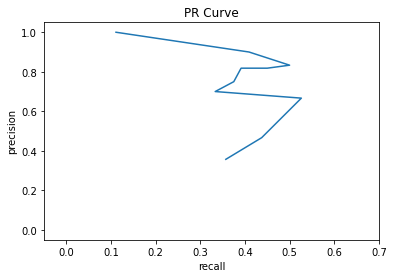

In [21]:
plt.plot(img_pc_cureve['recall'], img_pc_cureve['precision'])
plt.xlim(-0.05, 0.7)
plt.ylim(-0.05, 1.05)
plt.title('PR Curve')
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()